In [1]:
from theta.rtbm import RTBM
import numpy as np
import matplotlib.pyplot as plt
from theta.minimizer import CMA, SGD
from theta import costfunctions
%matplotlib inline

In [2]:
ndim = 1
nhid = 1
rtbm = RTBM(ndim, nhid, 
            minimization_bound=55, 
            positive_T=True, 
            positive_Q=True,
            gaussian_init=True           )

def espacio(sample, n=1e5):
    n = int(n)
    u = np.max(sample)
    l = np.min(sample)
    epsilon = np.abs(u)/4.0
    u += epsilon
    l -= epsilon
    r = np.random.rand(ndim, n)
    return l + r*(u-l), pow(u-l, ndim)/n

In [4]:
# Check that the integral integrates correctly
if True:
    nevt = int(1e5)
    ff = lambda x: np.prod(np.sin(x*np.pi), axis=0)
    def scale_01(x):
        xmax = np.max(x, axis=0)
        xmin = np.min(x, axis=0)
        return (x - xmin)/(xmax-xmin)

    print("- > Checking the RTBM for sanity")
    r, _ = rtbm.make_sample(nevt)
    rmean = np.mean(r, axis=0)
    rstd = np.std(r, axis=0)
    rmax = rmean + 5.0*rstd
    rmin = rmean - 5.0*rstd
    delta = rmax-rmin
    new_r = np.random.rand(ndim, nevt)*delta.reshape(ndim,1) + rmin.reshape(ndim, 1)
    px = rtbm(new_r)/nevt
    
    print(f"sum: {np.sum(px)}")
    print(f"N/V: {1/np.prod(delta)}")
    print(f"Integral=1: {np.prod(delta)*np.sum(px)}")
    
    def g(z):
        x = (z-rmin.reshape(ndim,1))/(rmax-rmin).reshape(ndim,1)
        return ff(x)

    print("- > Checking the actual result of the integral")
    random_uniform = np.stack([np.random.uniform(rmin[i], rmax[i], size=nevt) for i in range(ndim)], axis=0)
    res_true = ff(np.random.rand(ndim, nevt))/nevt
    res = g(random_uniform)/nevt
    print(f"Integral true result: {np.sum(res_true)}")
    print(f"Integral rescaled_result: {np.sum(res)}")
    
    print("- > Integrating with the simple RTBM g(z)")
    #r,  _ = rtbm.make_sample(nevt)
    prob_x = rtbm(r.T)[0]
    resbm = g(r.T)/nevt/prob_x/np.prod(delta)
    print(f"RTBM integral: {np.sum(resbm)}")
    
    print("- > Asking the RTBM for the probability and x between 0 and 1")
    # Now do everything from the RTBM
    rtbm_x, rho_x = rtbm.make_sample_rho(nevt)
    res = ff(rtbm_x.T)/nevt/rho_x
    print(f"RTBM sample integral: {np.sum(res)}")

- > Checking the RTBM for sanity
sum: 0.07186333282370232
N/V: 0.07181768563029521
Integral=1: 1.0006355982235642
- > Checking the actual result of the integral
Integral true result: 0.6349618735830673
Integral rescaled_result: 0.6373182790138161
- > Integrating with the simple RTBM g(z)
RTBM integral: 0.6276629808924321
- > Asking the RTBM for the probability and x between 0 and 1
RTBM sample integral: 0.6466512046168151


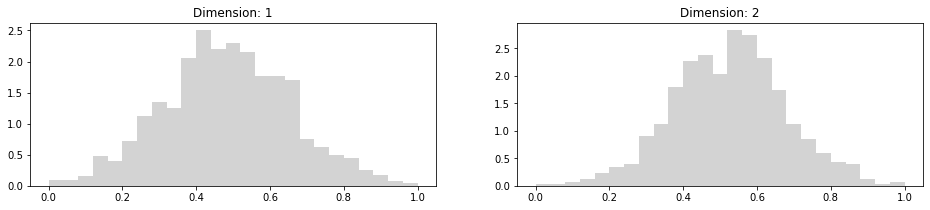

In [5]:
plt.rcParams['figure.figsize'] = [16, 3]

def do_rescale(xrand, y):
    max_per_d = np.max(xrand, axis=0)
    min_per_d = np.min(xrand, axis=0)
    delta = max_per_d - min_per_d
    new_rand = (xrand-min_per_d)/delta
    new_y = y*np.prod(delta)
    return new_rand, new_y

def dome(nevt=1e3, do_rho=True, rescale=True):
    # Sample after gaussian initialization
    nevt = int(nevt)
    xrand, _ = rtbm.make_sample(nevt)
    jac = rtbm(xrand.T)[0]
    
    if rescale:
        xrand, jac = do_rescale(xrand, jac)
    
    for d in range(ndim):
        plt.subplot(1,ndim,d+1)
        plt.title(f"Dimension: {d+1}")
        if do_rho:
            x = sorted(xrand[:,d])
            y = [i for _, i in sorted(zip(xrand[:,d], jac))]
            plt.plot(x, y, color="blue", label=f"p(x_{d+1})", alpha=0.5)
        plt.hist(xrand[:, d], bins=25, density=True, color="lightgray", label="Sample")
    plt.show()
    return xrand
xrand = dome(do_rho=False)

In [6]:
xrand.shape

(1000, 2)

In [4]:
r, jac = espacio(xrand, n=1e5)
aa = rtbm(r)
print(np.sum(aa)*jac)

0.006436717935757516


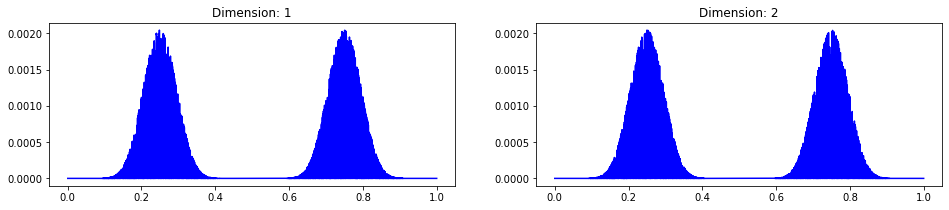

Current mse: 7.743793967984774e-06
Current KL: 5.854494520862714


In [5]:
# Now train the RTBM to a _different_ functional form
from scipy.special import expit
n = int(1e4)
ff = lambda x: np.prod(np.sin(x*np.pi*2)**12, axis=1)
xvals = np.random.rand(n, ndim)
yvals_raw = ff(xvals)
yvals = yvals_raw/np.sum(yvals_raw)
for d in range(ndim):
    plt.subplot(1,ndim,d+1)
    plt.title(f"Dimension: {d+1}")
    x = sorted(xvals[:,d])
    y = [i for _, i in sorted(zip(xvals[:,d], yvals))]
    plt.plot(x, y, color="blue", label=f"p(x_{d+1})")
    #plt.hist(xrand[:, d], bins=25, density=True, color="lightgray", label="Sample")
plt.show()

current_val = rtbm(xvals.T)[0]
print(f"Current mse: {costfunctions.mse.cost(current_val, yvals)}")
print(f"Current KL: {costfunctions.kullbackLeibler.cost(current_val, yvals)}")

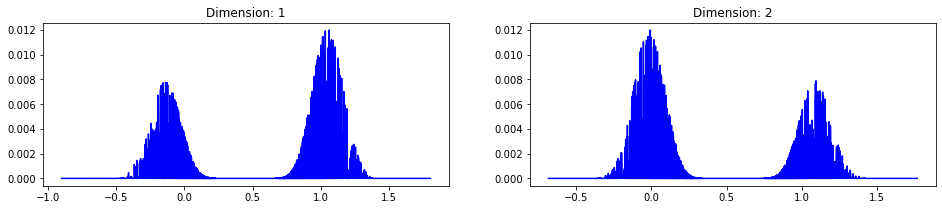

In [32]:
nevt = int(1e4)
xvals_train, _ = rtbm.make_sample(nevt)
jac = rtbm(xvals_train.T)
new_xvals, jac = do_rescale(xvals_train, jac)

# rescale the sample
yvals_train = ff(new_xvals)*jac
for d in range(ndim):
    plt.subplot(1,ndim,d+1)
    plt.title(f"Dimension: {d+1}")
    x = sorted(xvals_train[:,d])
    y = [i for _, i in sorted(zip(xvals_train[:,d], yvals_train[0]))]
    plt.plot(x, y, color="blue", label=f"p(x_{d+1})")
    #plt.hist(xrand[:, d], bins=25, density=True, color="lightgray", label="Sample")
plt.show()

In [35]:
from cma import CMAEvolutionStrategy

x0 = rtbm.get_parameters()
bounds = rtbm.get_bounds()

def optimize(n=1):
    sigma = np.min(bounds[1])/(4.0*n)
    es = CMAEvolutionStrategy(x0, sigma, {"bounds":bounds, "maxiter":250})
    # Create a function to be optimized:
    def fun_crate(xin, ytrue, mode = "kl"):
        def objective_fun(params=None):
            if params is not None and not rtbm.set_parameters(params):
                return np.NaN
            prob = rtbm(xin.T)
            if mode == "kl":
                return -np.sum(ytrue*np.log(prob))
            elif mode == "mse":
                return np.sum((prob-ytrue)**2)

        return objective_fun

    target = fun_crate(xvals_train, yvals_train, mode="kl")
    es.optimize(target)
    return es.result
    
n = 1
res = optimize(n)
while not rtbm.set_parameters(res.xbest):
    print("Rerunning the optimization, changing sigma")
    n+=1
    optimize(n)    

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=135632, Thu Feb 11 14:01:07 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 3.316916878277018e+00 1.0e+00 6.69e-01  6e-01  7e-01 0:00.4
    2     20 3.639818425206561e+00 1.2e+00 5.90e-01  6e-01  6e-01 0:00.9
    3     30 3.375289902653046e+00 1.2e+00 5.22e-01  5e-01  5e-01 0:01.3
   10    100 3.422018694426518e+00 1.6e+00 2.61e-01  2e-01  3e-01 0:04.4
   20    200 3.322803946827138e+00 2.9e+00 1.50e-01  8e-02  2e-01 0:08.7
   32    320 3.307592778614979e+00 4.1e+00 1.10e-01  4e-02  1e-01 0:13.8
   46    460 3.302494099136446e+00 8.2e+00 8.05e-02  2e-02  1e-01 0:19.9
   63    630 3.302127293821576e+00 1.5e+01 2.95e-02  6e-03  5e-02 0:27.1
   82    820 3.301986594688120e+00 2.8e+01 1.18e-02  2e-03  3e-02 0:35.4
  100   1000 3.301983983243518e+00 3.5e+01 3.71e-03  5e-04  8e-03 0:43.1
  124   1240 3.301983779928058e+00 7.2e+01 1.01e-03  8e-05  2e-03 0:53.4
  150   1500 3.301983775166147e+00

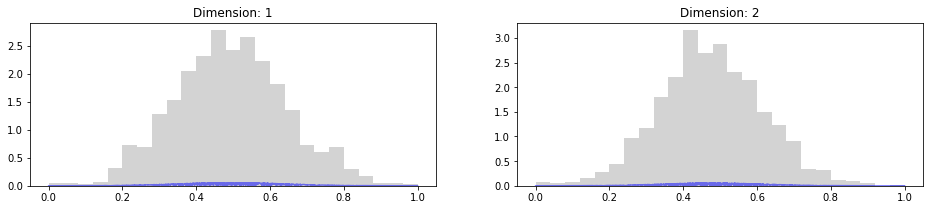

Current mse: 0.3016623357088076
Current KL: 0.6926201600497176
Integral:
0.7185666077998188


In [36]:
new_sample = dome(do_rho=True)
new_pred = rtbm(new_sample.T)[0]
new_y_raw = ff(new_sample)
new_y = new_y_raw/np.sum(new_y_raw)
print(f"Current mse: {costfunctions.mse.cost(new_pred, new_y)}")
print(f"Current KL: {costfunctions.kullbackLeibler.cost(new_pred, new_y)}")
print("Integral:")
r, jac = espacio(new_sample, n=1e5)
aa = rtbm(r)
print(np.sum(aa)*jac)